---
# Examples of 2-D classifications using SVM with Radial Basis Functions.
---

In this script, we show several examples of SVM classifications. The method is applied to a series 
of 2-D datasets, containing 2 classes, with an increasing level of spatial complexity. 
 
The SVM classifier with radial basis functions (RBF) performs well in problems with curvy or piecewise boundaries. Classical 
methods such as the linear discriminant analysis (LDA) and quadratic discriminant analysis (QDA) are more limited here since 
they are designed to tackle linear and quadratic boundaries between classes. Even the SVM classifier with 
polynomial kernels is limited in such situations since it requires high-degree polynomials to 
approximate complex boundaries. Such polynomials are well known for their wild oscillations which often 
make them useless.    

The performances of the SVM-RBF classifier explain why it was one of the most popular classifiers over many years.


In [1]:
print(__doc__)

# Author: Pierre Gravel <pierre.gravel@iid.ulaval.ca>
# License: BSD

%matplotlib inline
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import colors

from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
    
import scipy as sp
import scipy.spatial
from scipy.spatial.distance import cdist


from numpy import unravel_index
from copy import deepcopy
import seaborn as sns
sns.set()

# Used for reproductibility of the results
np.random.seed(42)

Automatically created module for IPython interactive environment


# Part I: Define a few useful functions

Let us first define several functions that will be used to generate each classification example.

### Find the best SVM classification for the available dataset and use it to map the influence zone of each class

In [2]:
def SVM_classification(X, y, figName):
    # Normalize the dataset and generate a spatial grid
    nbins = 400
    (X, Xgrid, xx, yy, x_min, x_max, y_min, y_max) = normalize_dataset(X, nbins)

    # Separate data into training (50 %) and test (50 %) datasets 
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size=0.5)

    # Find the best RBF SVM model with this dataset and make a copy
    model = find_optimal_SVM_model(X_train, y_train, X_test, y_test)
    model2 = deepcopy(model)

    # Train the model using the training dataset with the optimal parameter values to show margin and support vectors
    clf_train = model.fit(X_train, y_train)

    # Train the model using the complete dataset for best results overall
    clf_complete = model2.fit(X, y)


    # Display results
    fig, ax = plt.subplots(1,2,figsize = (15, 7.5))

    # Display the SVM margin and the support vectors using the training data
    plot_support_vectors(clf_train, X_train, y_train, xx, yy, ax[0])

    # Display the influence zone of each class
    display_classification_results(clf_complete, X, y, Xgrid, xx, yy, ax[1])
    fig.tight_layout()

    plt.savefig(figName + '.png')
    plt.savefig(figName + '.pdf')

### Normalize the dataset and generate a spatial grid where the class will be evaluated locally

In [3]:
def normalize_dataset(X, nbins):
    X = StandardScaler().fit_transform(X)
    x_min = 1.1 * X[:,0].min()
    x_max = 1.1 * X[:,0].max()
    y_min = 1.1 * X[:,1].min()
    y_max = 1.1 * X[:,1].max()

    # Generate a spatial grid 
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nbins), np.linspace(y_min, y_max, nbins))
    Xgrid = np.c_[xx.ravel(), yy.ravel()]
    
    return (X, Xgrid, xx, yy, x_min, x_max, y_min, y_max)

### Find the optimal SVM model with radial basis functions. 
The RBF SVM model has two free parameters, C and gamma, that must be evaluated on the dataset. We use a grid 
method to evaluate the best parameter values. 

In [4]:
def find_optimal_SVM_model(X_train, y_train, X_test, y_test):    

    # Find the nearest distance between any training point
    distances = cdist(X_train, X_train, 'euclidean')

    # An element is not its own nearest neighbor
    np.fill_diagonal(distances, sp.inf)

    # Find the smallest distance overall between training values. This is the minimum
    # spatial scale for the radial basis functions
    sigma_min = distances.min()    
    
    # Define (C,gamma) grid parameters
    gammas = np.array([1, 2, 4, 8, 16, 32, 64])*sigma_min
    C = np.logspace(-5,5,11)    
    
    
    # Get the classification score at each point of the parameter grid
    score = np.zeros([C.shape[0], gammas.shape[0]])
    for i, c in enumerate(C):
        for j, gamma in enumerate(gammas):
            # Define the model with the selected set of parameters. We take into account 
            # that the training set may not be balanced.
            model = SVC(kernel='rbf', C=c, gamma=gamma, class_weight='balanced')
            
            # Train the model
            clf = model.fit(X_train, y_train)

            # Test the model to get its classification score
            score[i,j] = clf.score(X_test, y_test)


    # Get the model with the best score
    (i,j) = unravel_index(np.argmax(score),score.shape)
    model = SVC(kernel='rbf', C=C[i], gamma=gammas[j], class_weight='balanced')
    
    return model

### Display the SVM margin and support vectors for the training dataset.
The margin is defined using the SVM discriminant function $h(X)$. The margin is the zone where $h(X) \in [-1, +1]$. The 
influence zone of each class is delimited by $h(X)=0$.

In [5]:
def plot_support_vectors(clf_train, X_train, y_train, xx, yy, ax):
    cm_bright = ListedColormap(['#00FF00', '#0000FF'])
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50, cmap=cm_bright, edgecolors='k')
    
    # Evaluate the discriminant function h(X) on the spatial grid
    xy = np.vstack([xx.ravel(), yy.ravel()]).T    
    h = clf_train.decision_function(xy).reshape(xx.shape)
    
    # Display the margin h(X) = {-1, 0, +1}
    cs = ax.contour(xx, yy, h, colors=['g', 'k', 'b'], levels=[-1, 0, 1], 
                    alpha=0.8, linestyles=['--', '-', '--'], linewidths=3)
    labels = ['$h(X)<0$', '$h(X)=0$', '$h(X)>0$']
    for i in range(len(labels)):
        cs.collections[i].set_label(labels[i])
 
    # Show the support vectors as circles around training data points
    ax.scatter(clf_train.support_vectors_[:, 0], clf_train.support_vectors_[:, 1],
               s=300, linewidth=1, facecolors='none',edgecolors='k');       
    
    ax.set_title('Classification using training dataset only',fontsize=18)

    x_min, x_max, y_min, y_max = xx.min(), xx.max(), yy.min(), yy.max()
    ax.set_xlim([x_min,x_max])
    ax.set_ylim([y_min,y_max])
    ax.set_xlabel('$x_{1}$', fontsize=14)
    ax.set_ylabel('$x_{2}$', fontsize=14, rotation=0) 
    ax.xaxis.set_label_coords(0.5, -0.05) 
    ax.yaxis.set_label_coords(-0.05, 0.5) 
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.legend(loc="best")
    ax.grid(None) 


### Display the influence zone of each class. 
The local class is evaluated at each point on the spatial grid using the SVM model that was trained 
on the complete dataset (training + test) using the optimum parameters.

In [6]:
def display_classification_results(clf, X, y, Xgrid, xx, yy, ax):

    Z = clf.predict(Xgrid) 
    Z = Z.reshape(xx.shape)

    cm_dim = ListedColormap(['#008800', '#000088'])
    cm_bright = ListedColormap(['#00FF00', '#0000FF'])
    
    ax.pcolormesh(xx, yy, Z, cmap=cm_dim, norm=colors.Normalize(0., 1.), zorder=0) 
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright, edgecolors='w')
    ax.set_title('Classification using complete dataset', fontsize=18, color='k')

    x_min, x_max, y_min, y_max = xx.min(), xx.max(), yy.min(), yy.max()
    ax.set_xlim([x_min,x_max])
    ax.set_ylim([y_min,y_max])
    ax.set_xlabel('$x_{1}$', fontsize=14)
    ax.set_ylabel('$x_{2}$', fontsize=14, rotation=0) 
    ax.xaxis.set_label_coords(0.5, -0.05) 
    ax.yaxis.set_label_coords(-0.05, 0.5) 
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(None)  


# Part II:  Examples of SVM classification using radial basis functions

## Example 1: Noisy crescents
The left panel shows the SVM margin that is defined as the zone where $h(X) \in [-1, +1]$. The large circles are the support vectors. 
The green and blue points belong to classes 0 and 1 respectively. The boundary between both classes is delineated by the curve 
$h(X)=0$. 

The left panel only shows training data. The (C, gamma) parameters in the RBF SVM algorithm were optimized using 
that data. The SVM model was then retrained using them with the complete dataset. The resulting classification is 
shown in the right panel. 

The boundaries $h(X)=0$ can be different in both panels because they use different amount of data 
(50% of the dataset on the left and 100% on the right). This explains the left-right differences visible in the 
examples that follow. The best results are always shown in the right panel since they
use all the available information, i.e. the complete dataset.     

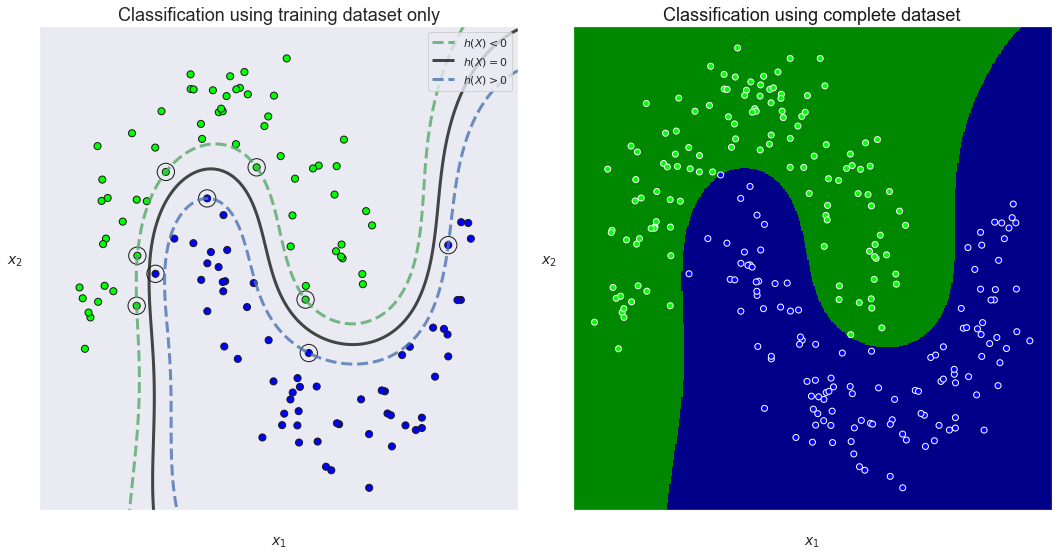

In [7]:
# Generate dataset
npts = 250
X,y = datasets.make_moons(n_samples=npts, noise=.15)

# Show SVM results: margins, support vectors, boundary and influence zone of each class
SVM_classification(X, y, figName='6.1.1_SVM_classification_crescents')


## Example 2: Concentric and separated noisy circles (easy case)

This is a very easy task for the SVM method. The QDA method would also perform well here but not the LDA. 
Notice in the left panel that almost every datapoint is a support vector and the margin encloses all of them.

Whereas the class boundary is elliptical in the left panel, it is circular in the right one and is located at mid distance between the two circles. 

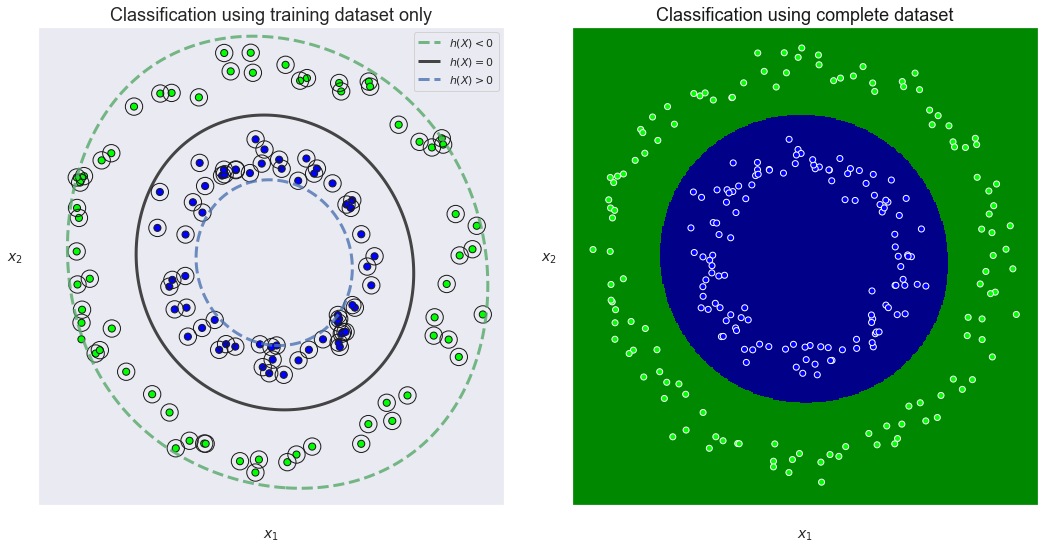

In [8]:
# Generate dataset
npts = 250
X,y = datasets.make_circles(n_samples=npts, factor=.5, noise=.05)

# Show SVM results: margins, support vectors, boundary and influence zone of each class
SVM_classification(X, y, figName='6.1.2_SVM_classification_separated_circles')

## Example 3: Concentric and overlapping noisy circles (more difficult case)

Overlapping distributions imply that there will be support vectors of each class on both sides of the boundary $h(X)=0$ as 
can be seen in the left panel. There are also less support vectors in this example.

The right panel shows an excellent delineation between the green and blue classes.

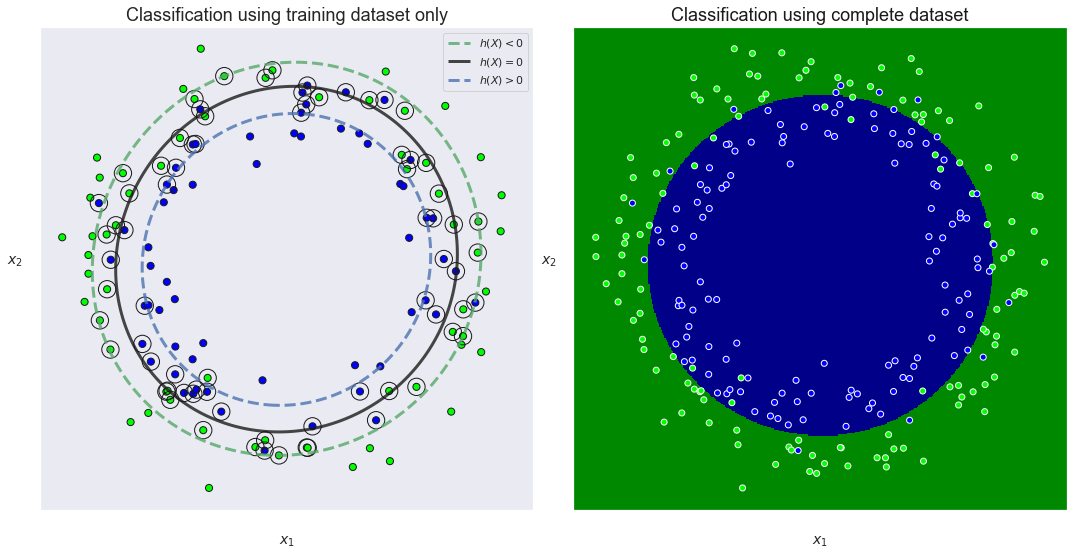

In [9]:
# Generate dataset
npts = 250
X,y = datasets.make_circles(n_samples=npts, factor=.75, noise=.1)

# Show SVM results: margins, support vectors, boundary and influence zone of each class
SVM_classification(X, y, figName='6.1.3_SVM_classification_overlapping_circles')

## Example 4: Square cross (much more difficult case)

In this example, the data points are uniformly distributed. There is a somewhat visible boundary between the green and 
the blue points; the latter are found inside a cross located in the center.

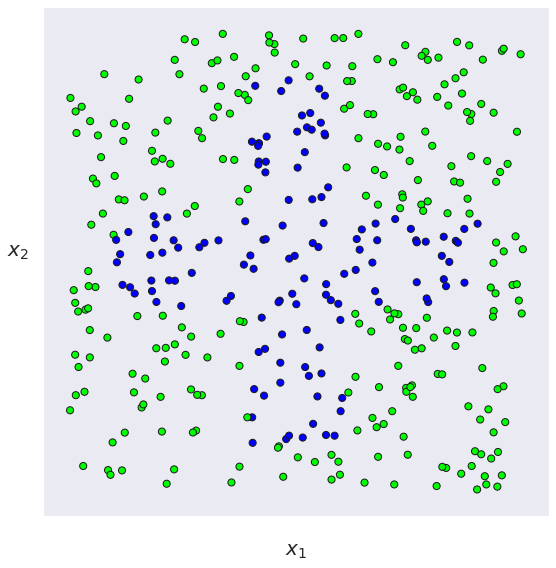

In [10]:
npts = 400
X = np.random.rand(npts,2)
y = np.zeros(npts,dtype=int)

for k, (x0,x1) in enumerate(zip(X[:,0], X[:,1])):
    y[k] = (x0>0.1 and x0<0.9) and (x1>0.4 and x1<0.6) or (x1>0.1 and x1<0.9) and (x0>0.4 and x0<0.6)
    

fig, ax = plt.subplots(figsize = (8, 8))
cm = ListedColormap(['#00FF00', '#0000FF'])
ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap=cm, edgecolors='k')
ax.set_xlabel('$x_{1}$', fontsize=20)
ax.set_ylabel('$x_{2}$', fontsize=20, rotation=0) 
ax.xaxis.set_label_coords(0.5, -0.05) 
ax.yaxis.set_label_coords(-0.05, 0.5) 
ax.set_aspect('equal')
ax.set_xticks([])
ax.set_yticks([])
ax.grid(None)  
fig.tight_layout()
    
plt.savefig('6.1.4_SVM_classification_cross.png')
plt.savefig('6.1.4_SVM_classification_cross.pdf')

The boundary is piecewise, i.e not smooth. Parametric methods such as LDA and QDA would be useless in this situation. Even the 
SVM method with polynomial kernels would do poorly. This is an example where the SVM method with RBF performs surprisingly well
as can be seen below.

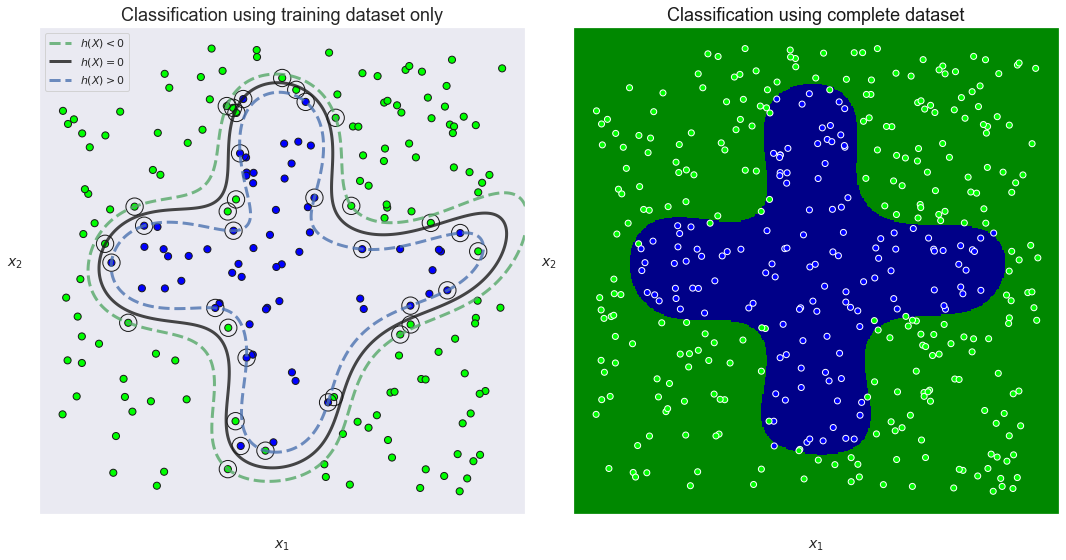

In [11]:
# Show SVM results: margins, support vectors, boundary and influence zone of each class
SVM_classification(X, y, figName='6.1.5_SVM_classification_cross')
